# Connect to the service

In [1]:
# only run on first load
# pip install trading-ig munch tenacity
from trading_ig.config import config

can't import config from config file


In [2]:
# Connecting to the service
from trading_ig.config import config
from trading_ig.rest import IGService

# Import information to convert the data to a data frame
import pandas as pd
# Import packages to save to CSV & JSON
import json, csv, os
# import time module for timestamps
from datetime import datetime, timedelta, date
import time

In [3]:
# Resolution offset 
from pandas.tseries.frequencies import to_offset

In [4]:
# cache session information and data 
import requests_cache
expire_after = timedelta(hours=1)
session = requests_cache.CachedSession(
    cache_name="cache", backend="sqlite", expire_after=expire_after)

In [5]:
# Connect to the data service api 
ig_service = IGService(config.username, config.password, config.api_key)
ig = ig_service.create_session()

In [6]:
# List of indeces starting with a single index
epics = {
    # "FTSE 100": "IX.D.FTSE.DAILY.IP",
    # "DAX 30": "IX.D.DAX.DAILY.IP",
    "Dow Jones": "IX.D.DOW.DAILY.IP",
    # "S&P 500": "IX.D.SPTRD.DAILY.IP",
    # "Nasdaq": "IX.D.NASDAQ.DAILY.IP",
}

epics

{'Dow Jones': 'IX.D.DOW.DAILY.IP'}

In [7]:
# Create a data varible to store results of the data export
data_folder = 'data'
historical_prices = {}

# Data by days
This call gets data based on the number of days

In [8]:
# Define the start date range for the historical prices
start_date = datetime.now() - timedelta(days=1)
s_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')
# s_date = '2023-01-07'

print(s_date)

# Define the end date range 
end_date = datetime.now()
e_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')
# e_date = '2023-02-23'

print(e_date)

# Define the interval for the historical prices

resolution= "1Min"

2023-03-08T06:09:22
2023-03-09T06:09:22


# Data by Days API CALL
This api call gets data by number of days, and can get large data sets exceeding the data call limits

In [9]:
# # # Fetch historical prices by determining the date range 

# # for index, epic in epics.items():
# #     result = ig_service.fetch_historical_prices_by_epic(
# #         epic = epic,
# #         start_date = f'{s_date}',
# #         end_date = f'{e_date}',
# #         resolution = f'{resolution}',
# #         pagesize= 1
# #         )
# #     # Use the following data for the parameters
# #     # epic: Any,
# #     # resolution: Any | None = None,
# #     # start_date: Any | None = None,
# #     # end_date: Any | None = None,
# #     # numpoints: Any | None = None,
# #     # pagesize: int = 20,
# #     # session: Any | None = None,
# #     # format: Any | None = None,
# #     # wait: int = 1
# #     print(result)
# #     prices = result['prices']
    
# #     # Getting todays date & time 
# #     # datetime.today().strftime('%Y-%m-%d %H:%M:%S')
    
# #     # Save the results to a folder
    
# #     os.makedirs(f'{data_folder}/{str(date.today())}', exist_ok=True)  
# #     prices.to_csv(f'{data_folder}/{str(date.today())}/data_{datetime.now()}.csv')  
# #     # # print(prices)
# #     # historical_prices[epic] = prices

# price data by number of points 
Extract and store data from the last 1000 data points

In [10]:
# change the number of data points to increase the information available
num_points = 1440

# if you want to cache this query
for index, epic in epics.items():
    response = ig_service.fetch_historical_prices_by_epic_and_num_points(epic, resolution, num_points)
    # Store raw prices to a local file
    df_prices = response['prices']
    df_prices.to_csv(f'data/dow-resolution-{resolution}-date-{e_date}.csv')
    print(response)
    df_prices.head()

{'prices':                          bid                                 ask           \
                        Open     High      Low    Close     Open     High   
DateTime                                                                    
2023-03-08 06:01:00  32849.6  32851.1  32846.1  32846.6  32854.4  32855.9   
2023-03-08 06:02:00  32847.1  32855.6  32847.1  32855.6  32851.9  32860.4   
2023-03-08 06:03:00  32856.6  32862.1  32856.6  32861.1  32861.4  32866.9   
2023-03-08 06:04:00  32860.6  32864.6  32860.6  32864.1  32865.4  32869.4   
2023-03-08 06:05:00  32864.6  32867.1  32860.6  32861.6  32869.4  32871.9   
...                      ...      ...      ...      ...      ...      ...   
2023-03-09 06:05:00  32765.7  32765.7  32763.2  32764.2  32770.5  32770.5   
2023-03-09 06:06:00  32763.7  32767.2  32763.7  32767.2  32768.5  32772.0   
2023-03-09 06:07:00  32767.7  32769.2  32765.7  32768.2  32772.5  32774.0   
2023-03-09 06:08:00  32767.7  32769.2  32766.7  32768.2  32772.5 

# Transform files
store the files downloaded to a local folder
- Trim columns to remove last values and only keep volume data
- Trim the number of columns to get bid, ask & volume only 

In [11]:
volume =  df_prices['last']
volume = volume.drop(columns=['Open','High', 'Low', 'Close'])
volume.head()

,Volume
DateTime,
2023-03-08 06:01:00,18
2023-03-08 06:02:00,43
2023-03-08 06:03:00,32
2023-03-08 06:04:00,15
2023-03-08 06:05:00,161


In [12]:
# create a dataframe for the bid & ask
bid_ask_data = df_prices[['bid', 'ask']]

# Combine the two data sources
clean_data = pd.concat([bid_ask_data, volume], axis=1)

clean_data.tail()

,"(bid, Open)","(bid, High)","(bid, Low)","(bid, Close)","(ask, Open)","(ask, High)","(ask, Low)","(ask, Close)",Volume
DateTime,,,,,,,,,
2023-03-09 06:05:00,32765.7,32765.7,32763.2,32764.2,32770.5,32770.5,32768.0,32769.0,7
2023-03-09 06:06:00,32763.7,32767.2,32763.7,32767.2,32768.5,32772.0,32768.5,32772.0,7
2023-03-09 06:07:00,32767.7,32769.2,32765.7,32768.2,32772.5,32774.0,32770.5,32773.0,9
2023-03-09 06:08:00,32767.7,32769.2,32766.7,32768.2,32772.5,32774.0,32771.5,32773.0,3
2023-03-09 06:09:00,32768.7,32769.2,32768.7,32769.2,32773.5,32774.0,32773.5,32774.0,1


In [13]:
# view the column headings 
list(clean_data.columns)

# rename the columns 
clean_data_2 = clean_data.rename(columns = {
    ('bid', 'Open'):'bid-open',
    ('bid', 'High'): 'bid-high',
    ('bid', 'Low'): 'bid-low',
    ('bid', 'Close'): 'bid-close',
    ('ask', 'Open'): 'ask-open',
    ('ask', 'High'): 'ask-high',
    ('ask', 'Low'): 'ask-low',
    ('ask', 'Close'): 'ask-close'
                                           })
clean_data_2.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,32854.4,32855.9,32850.9,32851.4,18
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,32851.9,32860.4,32851.9,32860.4,43
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32861.4,32866.9,32861.4,32865.9,32
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,32865.4,32869.4,32865.4,32868.9,15
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,32869.4,32871.9,32865.4,32866.4,161


In [14]:
clean_data_2.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,32854.4,32855.9,32850.9,32851.4,18
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,32851.9,32860.4,32851.9,32860.4,43
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32861.4,32866.9,32861.4,32865.9,32
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,32865.4,32869.4,32865.4,32868.9,15
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,32869.4,32871.9,32865.4,32866.4,161


# Save cleaned data
Save prices to a local folder

In [15]:
# Save to Json
clean_data_2.to_json(f'data/cleaned/dow-resolution-{resolution}-date-{e_date}.json')
# Save to csv
clean_data_2.to_csv(f'data/cleaned/dow-resolution-{resolution}-date-{e_date}.csv')

In [16]:
clean_data_2.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,32854.4,32855.9,32850.9,32851.4,18
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,32851.9,32860.4,32851.9,32860.4,43
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32861.4,32866.9,32861.4,32865.9,32
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,32865.4,32869.4,32865.4,32868.9,15
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,32869.4,32871.9,32865.4,32866.4,161


# Chart the data


In [17]:
data = clean_data_2
data.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,32854.4,32855.9,32850.9,32851.4,18
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,32851.9,32860.4,32851.9,32860.4,43
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32861.4,32866.9,32861.4,32865.9,32
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,32865.4,32869.4,32865.4,32868.9,15
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,32869.4,32871.9,32865.4,32866.4,161


In [18]:
# Delete unnecessary columns
# Return the following collumn values
chart_data = data.loc[:, ['bid-open', 'bid-high', 'bid-low', 'bid-close', 'Volume']]

chart_data = chart_data.rename(columns = {
    'bid-open':'open',
    'bid-high':'high',
    'bid-low':'low',
    'bid-close':'close',
    'Volume': 'volume'
                      })
chart_data.head()

,open,high,low,close,volume
DateTime,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,18
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,43
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,15
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,161


In [19]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

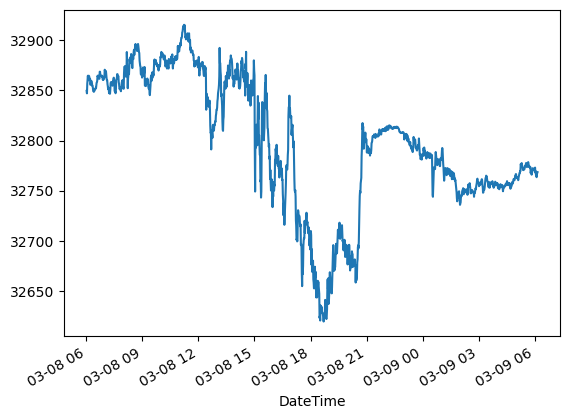

In [20]:
# Plot adjusted close price data
chart_data['open'].plot()
plt.show()

In [21]:
# Plotting candlestick 

In [22]:
import plotly.graph_objects as go
from datetime import datetime

import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [23]:
# Define a figure
# Charts work better with minute data

chart = go.Figure()

# add a trace for a Candlestick graph
chart.add_trace(go.Candlestick())

# Map each column to the correct value from the downloaded data
chart.add_trace(go.Candlestick(
    x=chart_data.index,
    open = chart_data['open'], 
    high=chart_data['high'], 
    low=chart_data['low'], 
    close=chart_data['close'], 
    name = 'market data'))


# Include shortcut buttons
chart.update_xaxes( rangeslider_visible=False, rangeselector=dict(
    buttons=list([
        dict(count=1, label='1 Period', step="hour", stepmode="backward"),
        dict(count=5, label='5 Periods', step="hour", stepmode="backward"),
        #dict(count=6, label='6 Periods', step="hour", stepmode="backward"),
        dict(count=10, label='10 Periods', step="hour", stepmode="backward"),
        dict(count=30, label='30 Periods', step="hour", stepmode="backward"),
        dict(step="all") 
    ]) 
))
chart.show()

In [24]:
# Plot moving averages on the chart
chart_data['MA50'] = chart_data['close'].rolling(window=50, min_periods=0).mean()
chart_data['MA200'] = chart_data['close'].rolling(window=200, min_periods=0).mean()
chart_data['MA200'].head(30)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(f'{epics}-Price Chart', 'Volume'), 
               row_width=[0.2, 0.7])

#Bottom chart displaying similar price data 
fig.add_trace(go.Candlestick(x=chart_data.index, open=chart_data["open"], high=chart_data["high"],
                low=chart_data["low"], close=chart_data["close"], name="OHLC"), 
                row=1, col=1)
#Price chart - 50 day moving average 
fig.add_trace(go.Scatter(x=chart_data.index, y=chart_data["MA50"], marker_color='grey',name="MA50"), row=1, col=1)

# Sub chart - 200 day moving average
fig.add_trace(go.Scatter(x=chart_data.index, y=chart_data["MA200"], marker_color='lightgrey',name="MA200"), row=1, col=1)

# no volume data exists
fig.add_trace(go.Bar(x=chart_data.index, y=chart_data['volume'], marker_color='red', showlegend=False), row=2, col=1)


In [25]:
# Remap the dataframe to existing data sources
data = chart_data
data.tail()

,open,high,low,close,volume,MA50,MA200
DateTime,,,,,,,
2023-03-09 06:05:00,32765.7,32765.7,32763.2,32764.2,7,32772.41,32761.455
2023-03-09 06:06:00,32763.7,32767.2,32763.7,32767.2,7,32772.25,32761.550
2023-03-09 06:07:00,32767.7,32769.2,32765.7,32768.2,9,32772.07,32761.650
2023-03-09 06:08:00,32767.7,32769.2,32766.7,32768.2,3,32771.91,32761.735
2023-03-09 06:09:00,32768.7,32769.2,32768.7,32769.2,1,32771.81,32761.820


In [26]:
# Compute the Bollinger Bands for the stock using the 50-day Moving average
n = 50

In [27]:

# Compute the Bollinger Bands 
def BBANDS(data, window=n):
    MA = data.close.rolling(window=n).mean()
    SD = data.close.rolling(window=n).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

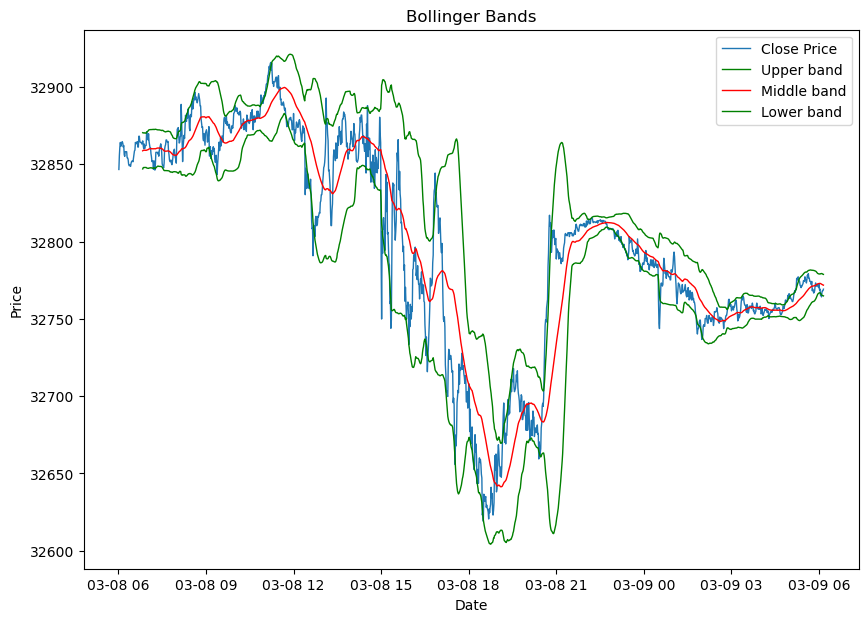

In [28]:

BBANDS = BBANDS(data, n)

# Create the plot
# pd.concat([BBANDS.Close, BBANDS.UpperBB, BBANDS.LowerBB],axis=1).plot(figsize=(9,5),)

plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(BBANDS.close,lw=1, label='Close Price')
plt.plot(data['UpperBand'],'g',lw=1, label='Upper band')
plt.plot(data['MiddleBand'],'r',lw=1, label='Middle band')
plt.plot(data['LowerBand'],'g', lw=1, label='Lower band')

# Add a legend to the axis
plt.legend()

plt.show()

# Technical indictors 
This uses a technical indicator library to calculate comment Technical analysis indictors
https://technical-analysis-library-in-python.readthedocs.io/en/latest/index.html

In [29]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [30]:
from ta import add_all_ta_features
from ta.utils import dropna

In [31]:
# Clean NaN values

df = clean_data_2
df = dropna(df)
df.tail()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-09 06:05:00,32765.7,32765.7,32763.2,32764.2,32770.5,32770.5,32768.0,32769.0,7.0
2023-03-09 06:06:00,32763.7,32767.2,32763.7,32767.2,32768.5,32772.0,32768.5,32772.0,7.0
2023-03-09 06:07:00,32767.7,32769.2,32765.7,32768.2,32772.5,32774.0,32770.5,32773.0,9.0
2023-03-09 06:08:00,32767.7,32769.2,32766.7,32768.2,32772.5,32774.0,32771.5,32773.0,3.0
2023-03-09 06:09:00,32768.7,32769.2,32768.7,32769.2,32773.5,32774.0,32773.5,32774.0,1.0


In [32]:
# Rename the features 
df = chart_data.rename(columns = {
    'open':'Open',
    'high':'High',
    'low':'Low',
    'close':'Close',
    'volume': 'Volume_BTC'
                      })
chart_data.head()
df.tail()

,Open,High,Low,Close,Volume_BTC,MA50,MA200,MiddleBand,UpperBand,LowerBand
DateTime,,,,,,,,,,
2023-03-09 06:05:00,32765.7,32765.7,32763.2,32764.2,7,32772.41,32761.455,32772.41,32779.320772,32765.499228
2023-03-09 06:06:00,32763.7,32767.2,32763.7,32767.2,7,32772.25,32761.550,32772.25,32779.266744,32765.233256
2023-03-09 06:07:00,32767.7,32769.2,32765.7,32768.2,9,32772.07,32761.650,32772.07,32779.029973,32765.110027
2023-03-09 06:08:00,32767.7,32769.2,32766.7,32768.2,3,32771.91,32761.735,32771.91,32778.850241,32764.969759
2023-03-09 06:09:00,32768.7,32769.2,32768.7,32769.2,1,32771.81,32761.820,32771.81,32778.759644,32764.860356


In [33]:
# Add ta features filling NaN values


df_ta = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume_BTC", fillna=True)

# Store data for later use 
df_ta.to_json(f'data/cleaned/dow-resolution-{resolution}-Indicators-date-{e_date}.json')
df_ta.to_csv(f'data/cleaned/dow-resolution-{resolution}-Indicators-date-{e_date}.csv')
df_ta.head()

/opt/conda/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning:

invalid value encountered in double_scalars



,Open,High,Low,Close,Volume_BTC,MA50,MA200,MiddleBand,UpperBand,LowerBand,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,18,32846.600000,32846.600000,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32846.600000,0.149659,0.000000,0.000000
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,43,32851.100000,32851.100000,NaN,NaN,NaN,...,0.002186,0.000437,0.001749,10.045924,2.009185,8.036739,32850.641925,0.027400,0.027396,0.027400
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32,32854.433333,32854.433333,NaN,NaN,NaN,...,0.005209,0.001391,0.003817,12.801686,4.167685,8.634001,32855.289958,0.016740,0.016739,0.044145
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,15,32856.850000,32856.850000,NaN,NaN,NaN,...,0.008246,0.002762,0.005484,8.801879,5.094524,3.707355,32859.509344,0.009129,0.009129,0.053278
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,161,32857.800000,32857.800000,NaN,NaN,NaN,...,0.009925,0.004195,0.005730,41.422282,12.360075,29.062206,32860.404378,-0.007607,-0.007607,0.045667


In [34]:
# from ta.volatility import BollingerBands
# Example of individual technical indicator usage 
# Initialize Bollinger Bands Indicator
# indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)

# Add Bollinger Bands features
# df['bb_bbm'] = indicator_bb.bollinger_mavg()
# df['bb_bbh'] = indicator_bb.bollinger_hband()
# df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
# df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
# df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# df.tail()

In [36]:
df_ta = df_ta.drop(columns=['MiddleBand','UpperBand', 'LowerBand'])
df_ta.head()

,Open,High,Low,Close,Volume_BTC,MA50,MA200,volume_adi,volume_obv,volume_cmf,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-03-08 06:01:00,32849.6,32851.1,32846.1,32846.6,18,32846.600000,32846.600000,-14.400000,18,-0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32846.600000,0.149659,0.000000,0.000000
2023-03-08 06:02:00,32847.1,32855.6,32847.1,32855.6,43,32851.100000,32851.100000,28.600000,61,0.468852,...,0.002186,0.000437,0.001749,10.045924,2.009185,8.036739,32850.641925,0.027400,0.027396,0.027400
2023-03-08 06:03:00,32856.6,32862.1,32856.6,32861.1,32,32854.433333,32854.433333,48.963636,93,0.526491,...,0.005209,0.001391,0.003817,12.801686,4.167685,8.634001,32855.289958,0.016740,0.016739,0.044145
2023-03-08 06:04:00,32860.6,32864.6,32860.6,32864.1,15,32856.850000,32856.850000,60.213636,108,0.557534,...,0.008246,0.002762,0.005484,8.801879,5.094524,3.707355,32859.509344,0.009129,0.009129,0.053278
2023-03-08 06:05:00,32864.6,32867.1,32860.6,32861.6,161,32857.800000,32857.800000,-51.247902,-53,-0.190513,...,0.009925,0.004195,0.005730,41.422282,12.360075,29.062206,32860.404378,-0.007607,-0.007607,0.045667


In [94]:
#Displaying volume correctly

indicator_fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(f'{epics}-Price Chart', 'Volume'), 
               row_width=[0.2, 0.8])

#Bottom chart displaying similar price data 
indicator_fig.add_trace(go.Candlestick(x=df_ta.index, open=df_ta["Open"], high=df_ta["High"],
                low=df_ta["Low"], close=df_ta["Close"], name="OHLC"), 
                row=1, col=1)
#Price chart - 50 day moving average 
#indicator_fig.add_trace(go.Scatter(x=df_ta.index, y=df_ta["volume_cmf"], marker_color='grey',name="volume_cmf"), row=2, col=1)

# Sub chart - 200 day moving average
#indicator_fig.add_trace(go.Scatter(x=chart_data.index, y=chart_data["MA200"], marker_color='lightgrey',name="MA200"), row=1, col=1)

# no volume data exists
indicator_fig.add_trace(go.Bar(x=df_ta.index, y=df_ta["Volume_BTC"], marker_color='green', showlegend=False), row=2, col=1)

#indicator_fig.add_trace(go.line(x))


In [104]:
#Displaying momentum_ppo_hist

indicator_fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(f'{epics}-Price Chart', 'momentum_ppo_hist'), 
               row_width=[0.8, 0.4])

#Bottom chart displaying similar price data 
indicator_fig.add_trace(go.Candlestick(x=df_ta.index, open=df_ta["Open"], high=df_ta["High"],
                low=df_ta["Low"], close=df_ta["Close"], name="OHLC"), 
                row=1, col=1)

# momentum indicator
indicator_fig.add_trace(go.Line(x=df_ta.index, y=df_ta["momentum_ppo_hist"], marker_color='black', showlegend=False), row=2, col=1)


In [105]:
df_ta2 = df_ta.drop(columns=["Open", "High","Low","Close", "Volume_BTC", "MA50", "MA200"])
df_ta2.head()

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-03-08 06:01:00,-14.400000,18,-0.800000,0.000000,0.000000e+00,0.000000e+00,0.022725,32847.933333,50.0,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32846.600000,0.149659,0.000000,0.000000
2023-03-08 06:02:00,28.600000,61,0.468852,387.000000,5.436047e+07,5.436047e+07,0.038721,32851.340437,100.0,1000.000000,...,0.002186,0.000437,0.001749,10.045924,2.009185,8.036739,32850.641925,0.027400,0.027396,0.027400
2023-03-08 06:03:00,48.963636,93,0.526491,356.857143,1.375000e+08,9.593023e+07,0.017139,32854.297133,100.0,1000.167399,...,0.005209,0.001391,0.003817,12.801686,4.167685,8.634001,32855.289958,0.016740,0.016739,0.044145
2023-03-08 06:04:00,60.213636,108,0.557534,312.306122,8.666667e+07,9.284238e+07,0.006726,32855.519753,100.0,1000.258708,...,0.008246,0.002762,0.005484,8.801879,5.094524,3.707355,32859.509344,0.009129,0.009129,0.053278
2023-03-08 06:05:00,-51.247902,-53,-0.190513,210.190962,5.046584e+06,7.089343e+07,-0.010878,32860.056629,100.0,1000.258708,...,0.009925,0.004195,0.005730,41.422282,12.360075,29.062206,32860.404378,-0.007607,-0.007607,0.045667


In [120]:
clms = df_ta2
clms.info()

number_of_clns =len(clms.columns)
print(number_of_clns)

print(f'There are {number_of_clns } columns in this dataframe')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2023-03-08 06:01:00 to 2023-03-09 06:09:00
Data columns (total 86 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   volume_adi                 1440 non-null   float64
 1   volume_obv                 1440 non-null   int64  
 2   volume_cmf                 1440 non-null   float64
 3   volume_fi                  1440 non-null   float64
 4   volume_em                  1440 non-null   float64
 5   volume_sma_em              1440 non-null   float64
 6   volume_vpt                 1440 non-null   float64
 7   volume_vwap                1440 non-null   float64
 8   volume_mfi                 1440 non-null   float64
 9   volume_nvi                 1440 non-null   float64
 10  volatility_bbm             1440 non-null   float64
 11  volatility_bbh             1440 non-null   float64
 12  volatility_bbl             1440 non-null   float64
 13  volatility_b

In [125]:
# Test to channel selection
print((clms).shape[1])
print((clms.))

86


In [140]:
# Trying to chart the full list of 86 indicators by printing a chart and their data separately
length = len.clms

for indicator in clms:
    print(f'indicator = {df.columns[indicator]}')
    indicator = column
    print(clms[f'{indictor}'])
    print(clms[])
    print ("-------------------------------------")

SyntaxError: invalid syntax (1025055667.py, line 6)

In [ ]:
indicator_fig.add_trace(go.Line(x=df_ta2.index, y=df_ta["momentum_ppo_hist"], marker_color='black', showlegend=False), row=2, col=1)
